In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

# 转换为Tensor，归一化
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# 下载训练集，应用转换
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=8
)

# 下载测试集，应用转换
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=8
)

# CIFAR-10的类别
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(1024, 64),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.model(x)

net = Net()

In [12]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/cifar10_experiment_1")

# 获取随机训练数据
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 写入模型图
writer.add_graph(net, images)
writer.close()

In [13]:
import torch.optim as optim

# 损失函数、优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 训练网络
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入数据
        inputs, labels = data

        # 梯度置零
        optimizer.zero_grad()

        # 前向传播、反向传播、优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print("Finished Training")

[1,  2000] loss: 1.892
[1,  4000] loss: 1.558
[1,  6000] loss: 1.440
[1,  8000] loss: 1.348
[1, 10000] loss: 1.276
[1, 12000] loss: 1.260
[2,  2000] loss: 1.139
[2,  4000] loss: 1.149
[2,  6000] loss: 1.119
[2,  8000] loss: 1.107
[2, 10000] loss: 1.098
[2, 12000] loss: 1.126
[3,  2000] loss: 0.993
[3,  4000] loss: 1.008
[3,  6000] loss: 1.021
[3,  8000] loss: 1.007
[3, 10000] loss: 1.009
[3, 12000] loss: 1.012
[4,  2000] loss: 0.909
[4,  4000] loss: 0.920
[4,  6000] loss: 0.921
[4,  8000] loss: 0.983
[4, 10000] loss: 0.951
[4, 12000] loss: 0.964
[5,  2000] loss: 0.849
[5,  4000] loss: 0.882
[5,  6000] loss: 0.900
[5,  8000] loss: 0.917
[5, 10000] loss: 0.920
[5, 12000] loss: 0.922
[6,  2000] loss: 0.805
[6,  4000] loss: 0.841
[6,  6000] loss: 0.883
[6,  8000] loss: 0.889
[6, 10000] loss: 0.903
[6, 12000] loss: 0.914
[7,  2000] loss: 0.775
[7,  4000] loss: 0.828
[7,  6000] loss: 0.836
[7,  8000] loss: 0.895
[7, 10000] loss: 0.887
[7, 12000] loss: 0.907
[8,  2000] loss: 0.742
[8,  4000] 

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of the network on the test images: %d %%" % (100 * correct / total))


Accuracy of the network on the test images: 61 %


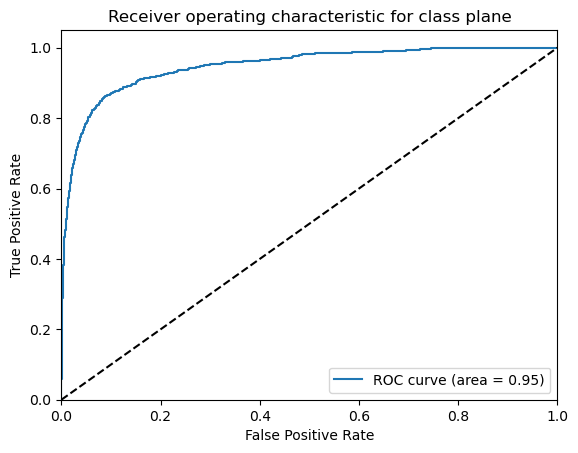

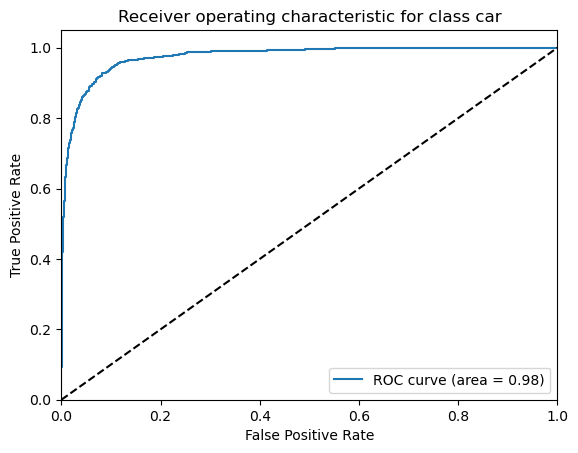

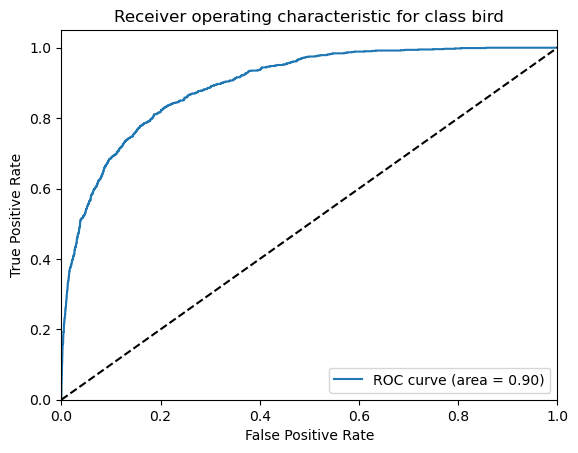

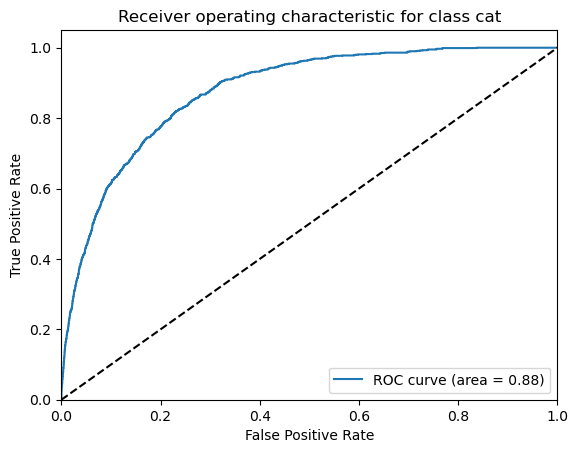

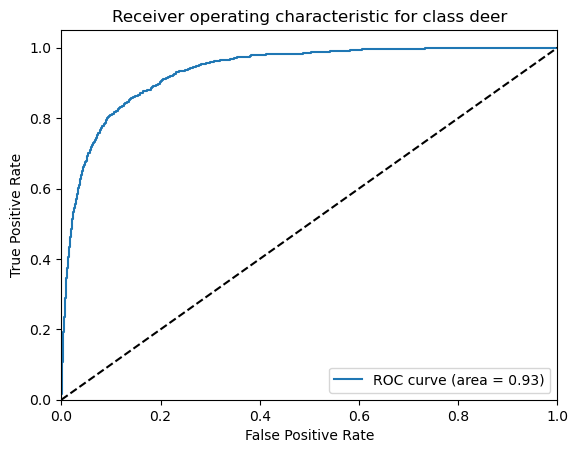

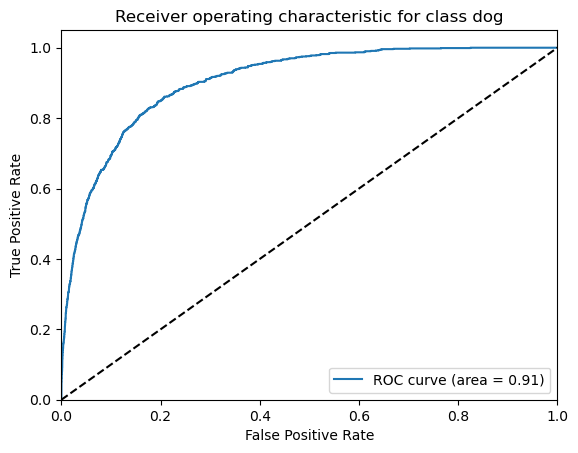

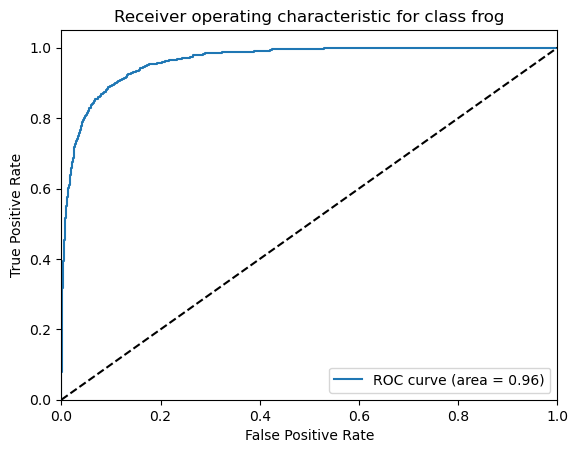

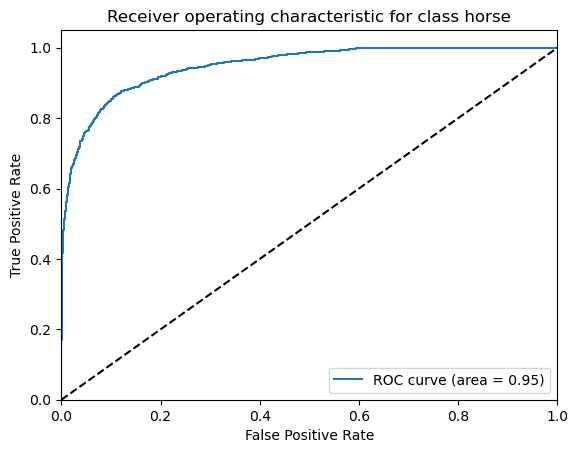

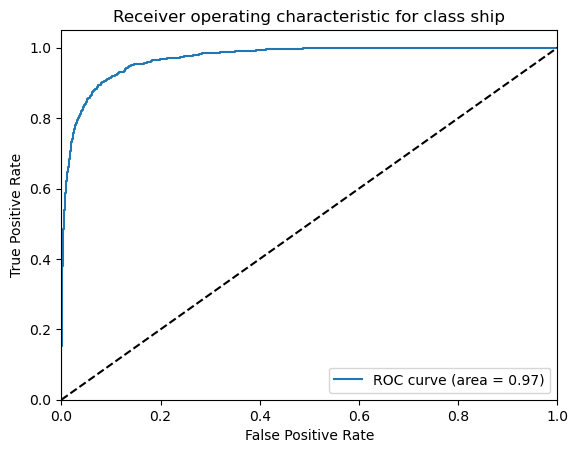

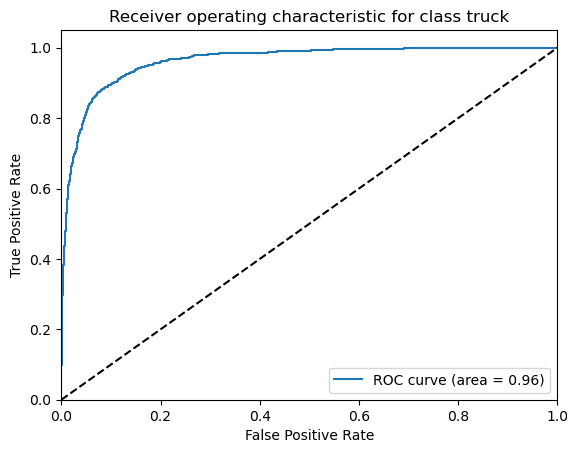

In [9]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 标签二值化
y_test = label_binarize(testset.targets, classes=list(range(10)))
n_classes = y_test.shape[1]

# 获取预测概率
y_score = np.zeros((len(testset), n_classes))

# 禁用梯度计算
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        outputs = net(images)
        probabilities = F.softmax(outputs, dim=1)
        y_score[i * testloader.batch_size : (i+1) * testloader.batch_size, :] = probabilities.numpy()

# 计算ROC和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class {}'.format(classes[i]))
    plt.legend(loc="lower right")
    plt.show()
